In [66]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [67]:
# LOAD ROBOT
robot = loadKinton()
robot.initDisplay(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [113]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [1]
    wBaseOri  = [500]
    wArmPos   = [1]
    wBaseVel  = [10]
    wBaseRate = [10]
    wArmVel   = [10] 
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wArmPos * (robot.model.nv - 6) + wBaseVel * robot.model.nv)
    controlWeights = np.array([0.1]*4 + [100]*6)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu =actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                    np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=1, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-7, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-4, cost=uRegCost)
    #runningCostModel.addCost(name="limu", weight=1e-3, cost=uLimCost)

    # DIFFERENTIAL ACTION MODEL
    dmodel = DifferentialActionModelUAM(rmodel, actModel, runningCostModel)
    model = IntegratedActionModelEuler(dmodel)
    model.timeStep =  integrationStep  
    return model   

In [114]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-3

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 500


# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [115]:
models = []
for i in range(0,len(target_pos)):
#    if (i==1):
#        T *=2
    models += [uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')]*T

q0 = rmodel.referenceConfigurations["initial_pose"]
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.12884e+02  3.67938e-02  1.31497e+03  1.00000e-09  1.00000e-09   1.0000     1
   1  2.38168e+02  4.37121e-02  4.15129e+02  1.00000e-09  1.00000e-09   1.0000     1
   2  2.07246e+02  3.80014e-02  8.08585e+01  1.00000e-09  1.00000e-09   0.5000     1
   3  2.01504e+02  6.09189e-03  1.26262e+01  1.00000e-09  1.00000e-09   1.0000     1
   4  2.00397e+02  1.11327e-02  2.47216e+00  1.00000e-09  1.00000e-09   1.0000     1
   5  2.00145e+02  4.89374e-04  9.23825e-01  1.00000e-09  1.00000e-09   1.0000     1
   6  1.99985e+02  4.08639e-04  7.66832e-01  1.00000e-09  1.00000e-09   1.0000     1
   7  1.99885e+02  2.97127e-04  6.72826e-01  1.00000e-09  1.00000e-09   1.0000     1
   8  1.99826e+02  2.78160e-04  5.62730e-01  1.00000e-09  1.00000e-09   1.0000     1
   9  1.99788e+02  3.32463e-04  4.99581e-01  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  1.99673e

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  1.99599e+02  3.32130e-05  6.49300e-03  1.00000e-09  1.00000e-09   1.0000     1
  91  1.99597e+02  4.47017e-05  8.43978e-03  1.00000e-09  1.00000e-09   0.5000     1
  92  1.99596e+02  3.66901e-07  9.40917e-04  1.00000e-09  1.00000e-09   1.0000     1
  93  1.99595e+02  4.64742e-07  9.53069e-04  1.00000e-09  1.00000e-09   1.0000     1
  94  1.99594e+02  6.07280e-07  9.76036e-04  1.00000e-09  1.00000e-09   1.0000     1
  95  1.99593e+02  7.73138e-07  1.00503e-03  1.00000e-09  1.00000e-09   1.0000     1
  96  1.99592e+02  1.01393e-06  1.04490e-03  1.00000e-09  1.00000e-09   1.0000     1
  97  1.99592e+02  1.30863e-06  1.09510e-03  1.00000e-09  1.00000e-09   1.0000     1
  98  1.99591e+02  1.71772e-06  1.16344e-03  1.00000e-09  1.00000e-09   1.0000     1
  99  1.99590e+02  2.23199e-06  1.24991e-03  1.00000e-09  1.00000e-09   1.0000     1


([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([ 5.85237457e-10,  6.69571510e-07,  4.25906477e-04,  4.17502505e-04,
         -3.62684019e-07, -4.68765744e-06,  9.99999913e-01, -9.56465445e-06,
          8.43478756e-04,  1.11094600e-06, -1.84457793e-07, -1.16338927e-06,
         -9.85723371e-06,  7.36290330e-07,  8.47388501e-04,  4.25906173e-01,
          8.35005034e-01, -7.25368058e-04, -9.37531516e-03, -9.56465445e-03,
          8.43478756e-01,  1.11094600e-03, -1.84457793e-04, -1.16338927e-03,
         -9.85723371e-03]),
  array([ 1.03432885e-09,  1.27302072e-06,  1.26476098e-03,  1.22073318e-03,
         -9.78886079e-07, -1.31160456e-05,  9.99999255e-01, -2.67855299e-05,
          2.46630307e-03,  3.48823902e-06, -5.54600309e-07, -3.45543133e-06,
         -2.89867371e-05,  1.55244230e-06,  1.97768966e-03,  8.38852477e-01,
          1.60646193e+00, -1.23191183e-03, -1.68568509e-02, -1.72208754e-02,
     

In [116]:
displayTrajectory(robot, ddp.xs, dt)

In [109]:
# Control trajectory
f1 = []
f2 = [];
f3 = [];
f4 = [];

for u in ddp.us:
    f1.append(u[0])
    f2.append(u[1])
    f3.append(u[2])
    f4.append(u[3])

# State trajectory
Xx = [];
Xy = [];
Xz = [];
Vx = [];
Vy = [];
Vz = [];


for x in ddp.xs:
    Xx.append(x[0])
    Xy.append(x[1])
    Xz.append(x[2])
    Vx.append(x[13])
    Vy.append(x[14])
    Vz.append(x[15])

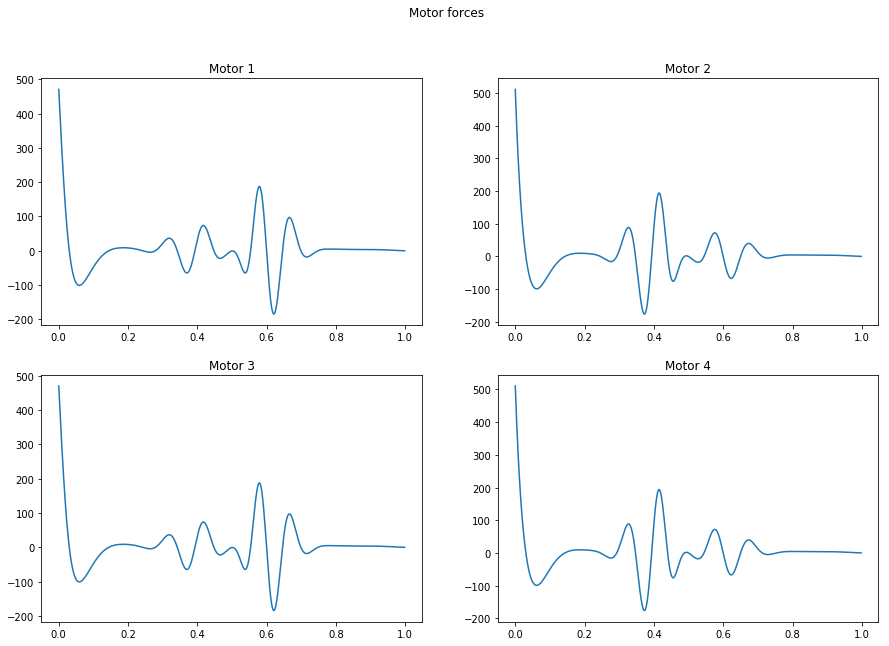

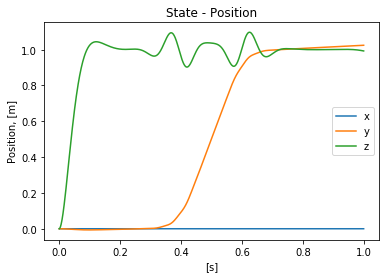

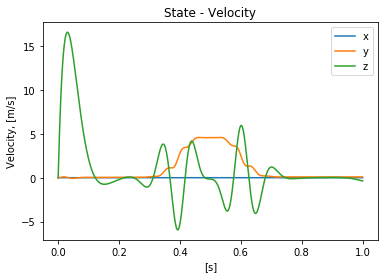

In [112]:
import matplotlib.pyplot as plt
t = np.arange(0., 1-dt, dt)

fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Motor forces')
axs[0, 0].plot(t,f1)
axs[0, 0].set_title('Motor 1')
axs[0, 1].plot(t,f2)
axs[0, 1].set_title('Motor 2')
axs[1, 0].plot(t,f3)
axs[1, 0].set_title('Motor 3')
axs[1, 1].plot(t,f4)
axs[1, 1].set_title('Motor 4')

plt.figure()
t = np.append(t, 1)
plt.plot(t,Xx,t,Xy,t,Xz)
plt.legend(['x','y','z'])
plt.title('State - Position')
plt.ylabel('Position, [m]')
plt.xlabel('[s]')

plt.figure()
plt.plot(t,Vx,t,Vy,t,Vz)
plt.legend(['x','y','z'])
plt.title('State - Velocity')
plt.ylabel('Velocity, [m/s]')
plt.xlabel('[s]')